<a href="https://colab.research.google.com/github/hyunicecream/Natural-Language-Processing-NLP-/blob/main/7_19_(%EB%84%A4%EC%9D%B4%EB%B2%84%EC%98%81%ED%99%94%EB%A6%AC%EB%B7%B0_CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install konlpy

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout
from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import roc_auc_score
from scipy import stats


train_data = pd.read_table('/content/drive/MyDrive/머신러닝/naver_ratings.txt', header=0, delimiter='\t', quoting=3)
train_data[0:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [ ]:
# 리뷰 개수 출력
print(len(train_data))

200000


In [ ]:
# Null 값 확인
print(train_data.isnull().sum())

id          0
document    8
label       0
dtype: int64


In [ ]:
# Null 값 제거
train_data = train_data.dropna()
print(train_data.isnull().sum())

id          0
document    0
label       0
dtype: int64


In [ ]:
print(len(train_data))

199992


In [ ]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]", "")
train_data[0:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [ ]:
 # 불용어 정의
stopwords = ['은', '는', '이', '가', '하', '아', '것', '들', '의', '있', '되', '수', '보', '주', '등', '한', 
             '의','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
# 형태소 분석기 OKT를 사용한 토큰화 작업 
okt = Okt()
tokenized_data = []
for sentence in train_data['document']:
  temp_X = okt.morphs(sentence, stem=True) # 토큰화
  temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
  tokenized_data.append(temp_X)

In [ ]:
# 리뷰 길이 분포 확인
print('리뷰의 최대길이:', max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))

리뷰의 최대길이: 70
리뷰의 평균 길이 : 10.59911896475859


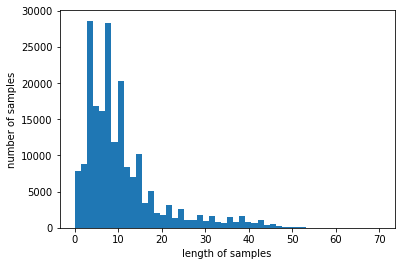

In [ ]:
# 그래프로 보기
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
tokenized_data = x_train, x_test

In [ ]:
# 학습 데이터
x_train, x_test, y_train, y_test = train_test_split(train_data['document'], train_data['label'], test_size = 0.3)

In [ ]:
x_train = np.array(x_train).reshape(-1,1)
x_test = np.array(x_test).reshape(-1,1)

In [ ]:
# 각 리뷰의 길이를 max_seq_len로 맞춘다. 길면 자르고, 짧으면 padding을 추가한다.
MAX_SEQ_LEN = 120
x_train = pad_sequences(x_train, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

# CNN 모델을 빌드한다.
VOCAB_SIZE = len(word2idx)
EMB_SIZE = 32
NUM_FILTER = 32

# Convolution & Pooling
def conv1d_maxpool(x, k):
    conv = Conv1D(filters=NUM_FILTER, kernel_size=k, activation='relu',
               kernel_regularizer=regularizers.l2(0.005))(x)
    return GlobalMaxPool1D()(conv)

x_input = Input(batch_shape=(None, x_train.shape[1]))
emb = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE)(x_input)
emb = Dropout(rate=0.5)(emb)

pool1 = conv1d_maxpool(emb, k=3)  # 3-gram
pool2 = conv1d_maxpool(emb, k=4)  # 4-gram
pool3 = conv1d_maxpool(emb, k=5)  # 5-gram
concat = Concatenate()([pool1, pool2, pool3])
y_output = Dense(1, activation='sigmoid')(concat)

model = Model(x_input, y_output)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005))
model.summary()